# SMACT Structure Prediction Module

In this tutorial you will learn how to start with a chemical composition, retrieve and represent a structure, store it in a database, and then generate dopant/structure‐predictions using ion‐mutation and substitution probability models. Feel free to modify the code cells and experiment as you go!

```{note}
This tutorial assumes you have installed the SMACT code (or have it in your working directory) along with its dependencies (e.g. pymatgen, pandas, numpy, etc.). For structure retrieval from the Materials Project, you will need a valid API key. (If you do not have one, see the Materials Project website or try the “from file” methods.)
```



Welcome! In this notebook you will learn how the SMACT structure prediction codebase works. We will:


1. **Retrieve and Represent a Structure**

    Start from a chemical composition and fetch a structure (or load from a file) using the `SmactStructure` class.


2. **Store and Query Structures in a Database**

    Use `StructureDB` as a lightweight `SQLite` interface to store and later retrieve structures.


3. **Perform Ion Mutation/Dopant Prediction**

    Use the `CationMutator class (backed by a lambda table of substitution probabilities) to generate candidate doped structures.


4. **Predict New Structures**

    Use `StructurePredictor` to find candidate parent structures from a database and propose substitutions.


5. **Experiment with Probability Models**

    Explore how to use a physically motivated probability model (the `RadiusModel`) to compute substitution probabilities.


Let’s work through these one step at a time.

In [1]:
# If you are using Google Colab, install the latest version of SMACT:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    %pip install "smact[strict] @ git+https://github.com/WMD-group/SMACT.git@master" --quiet


In [2]:
# Import future annotations first
from __future__ import annotations

# Import the SMACT modules.
# (Make sure your PYTHONPATH is set so that smact is importable.)
from smact.structure_prediction.probability_models import RadiusModel
from smact.structure_prediction.database import StructureDB, parse_mprest
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.utilities import parse_spec, unparse_spec
from pymatgen.ext.matproj import MPRester
from pymatgen.core import SETTINGS
import pymatviz as pmv
# Import standard packages and set up our environment.
import os
from operator import itemgetter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Increase display options for DataFrames.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# If you are running in a notebook, display plots inline.
%matplotlib inline
api_key = os.environ.get("MP_API_KEY", "YOUR_MP_API_KEY")



## 1. Retrieving and Representing a Structure from a Composition

The heart of our pipeline is the representation of a crystal structure. SMACT provides the `SmactStructure` class (in structure.py) which can be instantiated in several ways. For example, you can download a structure from the **Materials Project** or load a structure from a file (e.g. a **POSCAR**).

Below we demonstrate fetching a structure for a sample composition – for example, `CaTiO₃`.

```{note}
Tip: If you do not have a valid Materials Project API key, you can skip this cell and load a structure from file instead.
```

In [3]:
# Retrieve the structure from the Materials Project (make sure you have an API key configured)
# We need to specify a list containing tuples of (element, oxidation state, stoichiometry)
cspbi3_species = [("Cs", 1, 1), ("Pb", 2, 1), ("I", -1, 3)]

cspbi3_sstruct = SmactStructure.from_mp(species=cspbi3_species)


Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:

# Print the SmactStructure in POSCAR-like format
print("SmactStructure object for CsPbI3:")
print(cspbi3_sstruct)


SmactStructure object for CsPbI3:
Cs1+ I1- Pb2+
1.0
6.27514229 0.0 -0.0
0.0 6.27514229 0.0
0.0 0.0 6.27514229
Cs I Pb
1 3 1
Cartesian
3.137571145 3.137571145 3.137571145 Cs1+
0.0 0.0 3.137571145 I1-
0.0 3.137571145 0.0 I1-
3.137571145 0.0 0.0 I1-
0.0 0.0 0.0 Pb2+



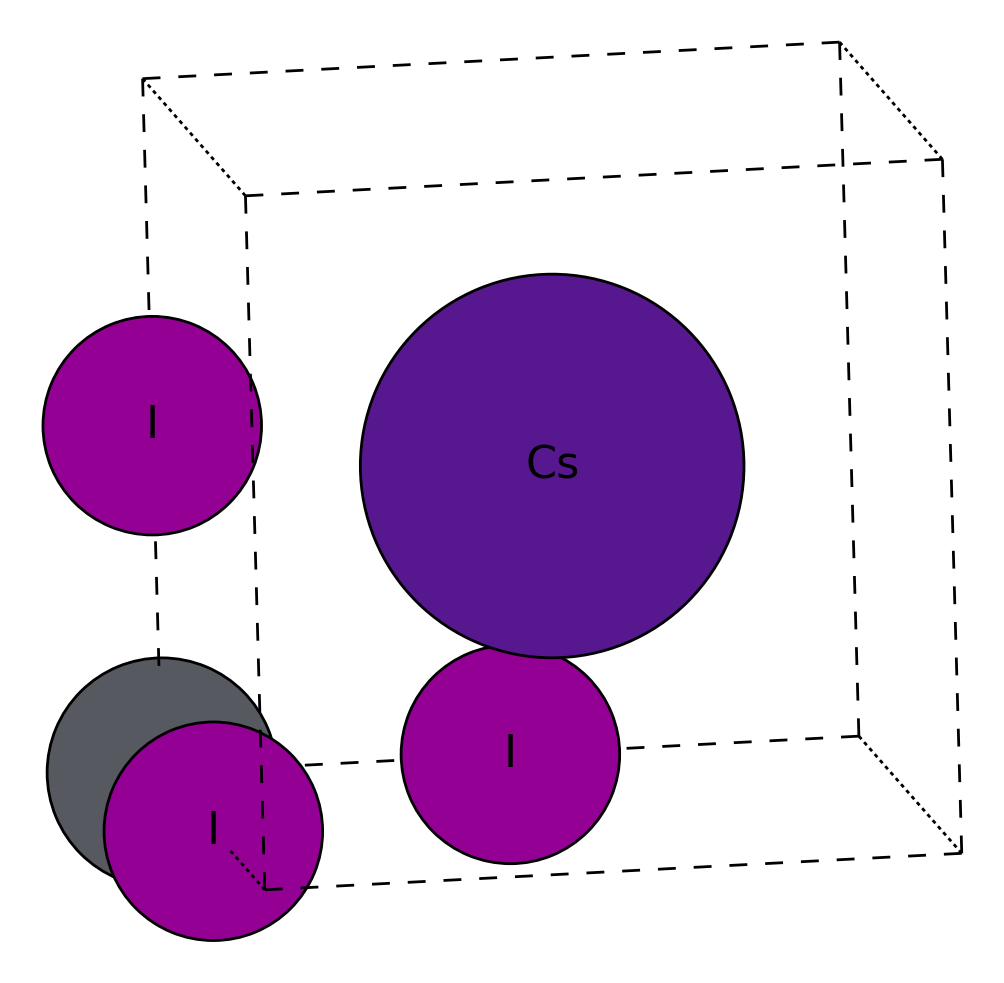

In [5]:

# Visualize the structure using pymatviz
pmv.structure_2d(cspbi3_sstruct.as_py_struct())
plt.show()


In [6]:

# List the species present
print("\nSpecies in CsPbI3 (tuple format):")
for spec in cspbi3_sstruct.species:
    print(spec)
    
print("\nSpecies as strings:")
print(cspbi3_sstruct.get_spec_strs())



Species in CsPbI3 (tuple format):
('Cs', 1, 1)
('I', -1, 3)
('Pb', 2, 1)

Species as strings:
['Cs1+', 'I1-', 'Pb2+']


In [7]:

# Check if Cs is present
has_cs = cspbi3_sstruct.has_species(("Cs", 1))
print(f"\nDoes the CsPbI3 structure contain Cs? {has_cs}")


Does the CsPbI3 structure contain Cs? True


```{exercise}
play around by changing the input species (composition) to see how the output structure and its POSCAR change. 
Try make one for `species = [("Ca", 2, 1), ("Ti", 4, 1), ("O", -2, 3)]`
```

Retrieving SummaryDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Structure retrieved from Materials Project!
Reduced formula: CaTiO3

POSCAR representation:

Ca2+ O2- Ti4+
1.0
-2.68573015 2.68573015 3.89611961
2.68573015 -2.68573015 3.89611961
2.68573015 2.68573015 -3.89611961
Ca O Ti
2 6 2
Cartesian
2.68573015 0.0 1.948059805 Ca2+
-2.220446049250313e-16 2.6857301500000004 1.948059805 Ca2+
-1.027577758921372 1.658152391078628 3.89611961 O2-
1.027577758921372 1.658152391078628 2.220446049250313e-16 O2-
1.658152391078628 1.027577758921372 3.8961196100000004 O2-
3.7133079089213714 1.0275777589213722 7.014688707853907e-17 O2-
-1.1102230246251565e-16 1.1102230246251565e-16 5.844179415 O2-
0.0 0.0 1.948059805 O2-
0.0 0.0 3.89611961 Ti4+
0.0 0.0 0.0 Ti4+



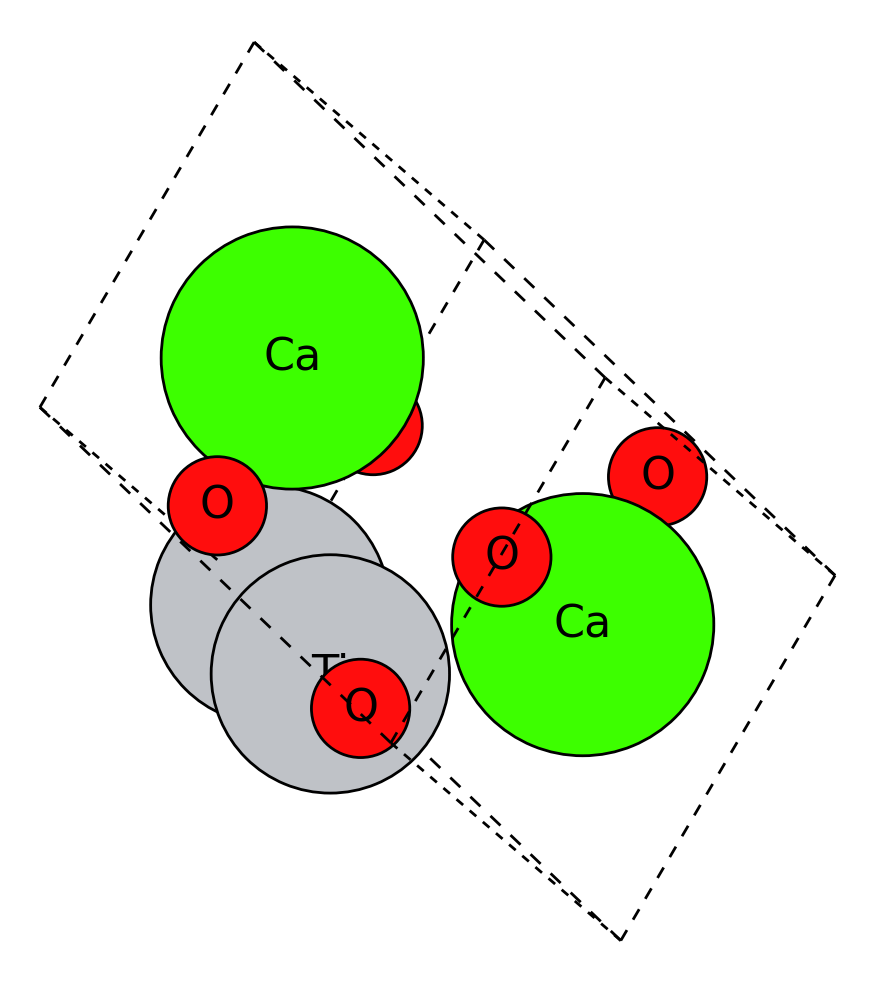

In [8]:
#note to self, use that python package that removes the answer from the cell

try:
    # Note: SmactStructure.from_mp takes a species list. For CaTiO3, we provide the constituent ions.
    species = [("Ca", 2, 1), ("Ti", 4, 1), ("O", -2, 3)]
    structure_mp = SmactStructure.from_mp(species, api_key=api_key, determine_oxi="BV")
    
    print("Structure retrieved from Materials Project!")
    print("Reduced formula:", structure_mp.reduced_formula())
    print("\nPOSCAR representation:\n")
    print(structure_mp.as_poscar())
    
    # Visualize the structure using pymatviz
    pmv.structure_2d(structure_mp.as_py_struct())
    plt.show()
    
except Exception as e:
    print("An error occurred fetching structure from MP. You may want to try loading from a file instead.")
    print(e)

## 2. The `CationMutator` class

Here we will introduce users to the CationMutator in `smact.structure_prediction.mutation` module. The `CationMutator` class is used to handle the substitution probabilities of different ionic species. 

We can use the `sub_prob` method to get the substitution probabilities of two different ionic species. The `sub_prob` method takes two arguments, the first argument is the ionic species to be substituted, and the second argument is the ionic species to be substituted with. The `sub_prob` method returns the substitution probability of the two ionic species.

Additionally, the `pair_corr` method computes the pair correlation.

In [9]:
# Instantiate the CationMutator - It uses a lambda table to assign probabilities (and pair correlations) based on ionic substitution data.
# Below we use the from_json() method to load a default (pymatgen) lambda table.
mutator = CationMutator.from_json()  # No arguments -> use pymatgen's lambda table

# Calculate substitution probabilities and pair correlations for a few examples.
p_Ba_Sr = mutator.sub_prob("Ba2+", "Sr2+")
p_Ba_Cs = mutator.sub_prob("Ba2+", "Cs1+")
p_Ba_Li = mutator.sub_prob("Ba2+", "Li1+")

g_Ba_Sr = mutator.pair_corr("Ba2+", "Sr2+")
g_Ba_Cs = mutator.pair_corr("Ba2+", "Cs1+")
g_Ba_Li = mutator.pair_corr("Ba2+", "Li1+")

print(f"\nSubstitution probabilities and pair correlations:")
print(f"Ba2+ → Sr2+: Probability = {p_Ba_Sr:.3g}, Pair Correlation = {g_Ba_Sr:.3g}")
print(f"Ba2+ → Cs1+: Probability = {p_Ba_Cs:.3g}, Pair Correlation = {g_Ba_Cs:.3g}")
print(f"Ba2+ → Li1+: Probability = {p_Ba_Li:.3g}, Pair Correlation = {g_Ba_Li:.3g}")



Substitution probabilities and pair correlations:
Ba2+ → Sr2+: Probability = 0.00276, Pair Correlation = 3.86
Ba2+ → Cs1+: Probability = 0.00569, Pair Correlation = 3.99
Ba2+ → Li1+: Probability = 2.21e-05, Pair Correlation = 0.038


From the above outputs, we can see that Ba<sup>2+</sup> is more likely to be substituted with Cs<sup>+</sup>, compared to Sr<sup>2+</sup> with Li<sup>+</sup> being two orders of magnitude less likely.

The `CationMutator` can also be used to produce a list of possible structures with the `unary_substitute` method. The `unary_substitute` method takes a `SmactStructure` object and returns a list of `SmactStructure` objects with the cations substituted according to the substitution probabilities.


Number of candidate substituted structures for CsPbI3: 59

First candidate substitution:
Substitution: Ag1+ replacing Cs1+
Probability: 0.0262
Mutated structure (reduced formula): AgPbI3


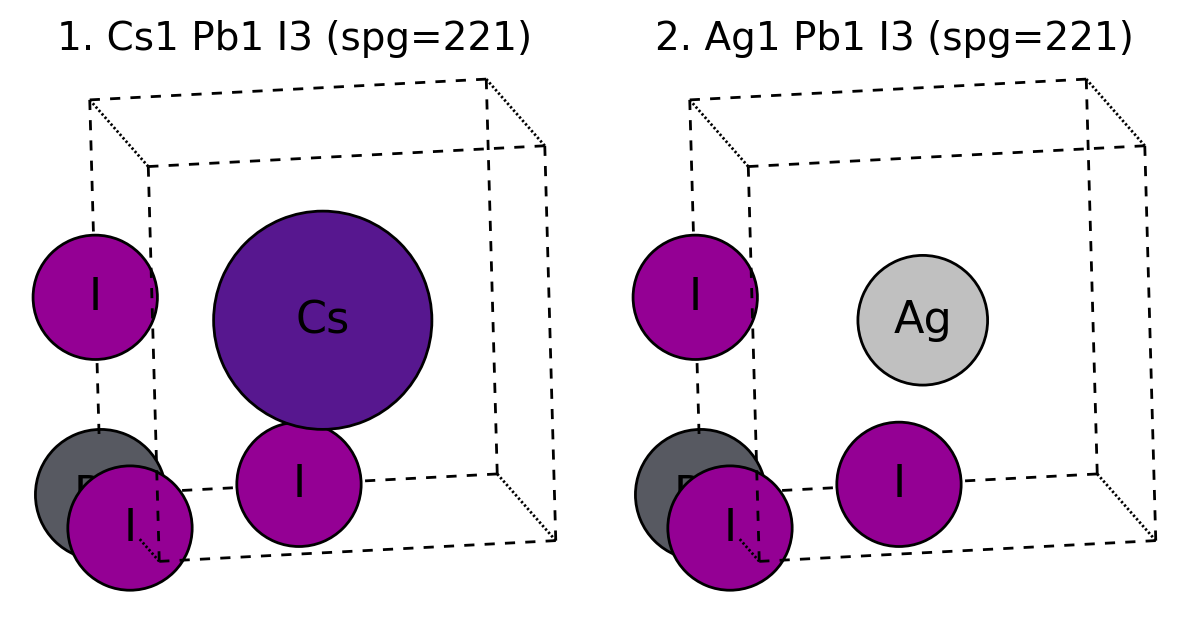

In [10]:

# Use unary_substitute to generate candidate doped structures for CsPbI3.
candidate_structures = list(mutator.unary_substitute(cspbi3_sstruct, thresh=0.001))
print(f"\nNumber of candidate substituted structures for CsPbI3: {len(candidate_structures)}")

if candidate_structures:
    # Each candidate is a tuple: (mutated_structure, probability, original_species, substituted_species)
    first_candidate = candidate_structures[0]
    mutated_struct, prob, original_spec, new_spec = first_candidate
    print(f"\nFirst candidate substitution:")
    print(f"Substitution: {new_spec} replacing {original_spec}")
    print(f"Probability: {prob:.3g}")
    print("Mutated structure (reduced formula):", mutated_struct.reduced_formula())
    
    # Visualize the original and the mutated structure
    pmv.structure_2d([cspbi3_sstruct.as_py_struct(), mutated_struct.as_py_struct()])
    plt.show()
else:
    print("No candidate substitutions found. Try lowering the threshold or check your lambda table.")


Overall, with the threshold of 1 x 10<sup>-3</sup>, there are 59 possible substituted structures for CsPbI<sup>3</sup>. The returned list isn't sorted by probability, so let's first organise the list.

In [11]:
# Store the candidate structures in a dataframe

candidate_df = pd.DataFrame(candidate_structures, columns=["Structure", "Probability", "Original Species", "Substituted Species"])
# Sort the dataframe by probability
candidate_df = candidate_df.sort_values(by="Probability", ascending=False).reset_index(drop=True)

# Show the first 5 rows of the dataframe
candidate_df.head()

,Structure,Probability,Original Species,Substituted Species
0,I1- Pb2+ Rb1+\n1.0\n6.27514229 0.0 -0.0\n0.0 6...,0.165778,Cs1+,Rb1+
1,Br1- Cs1+ Pb2+\n1.0\n6.27514229 0.0 -0.0\n0.0 ...,0.138700,I1-,Br1-
2,I1- Pb2+ Tl1+\n1.0\n6.27514229 0.0 -0.0\n0.0 6...,0.102270,Cs1+,Tl1+
3,I1- K1+ Pb2+\n1.0\n6.27514229 0.0 -0.0\n0.0 6....,0.089402,Cs1+,K1+
4,I1- In1+ Pb2+\n1.0\n6.27514229 0.0 -0.0\n0.0 6...,0.086309,Cs1+,In1+


From the dataframe above, we can see that the most probable substitution is Cs<sup>+</sup> with Rb<sup>+</sup> with a probability of 0.166, followed by the substitution of of I<sup>-</sup> with Br<sup>-</sup> with a probability of 0.139. 

(<Figure size 1800x1200 with 6 Axes>,
 array([[<Axes: title={'center': '1. Cs1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '2. Rb1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '3. Cs1 Pb1 Br3 (spg=221)'}>],
        [<Axes: title={'center': '4. Tl1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '5. K1 Pb1 I3 (spg=221)'}>,
         <Axes: title={'center': '6. In1 Pb1 I3 (spg=221)'}>]],
       dtype=object))

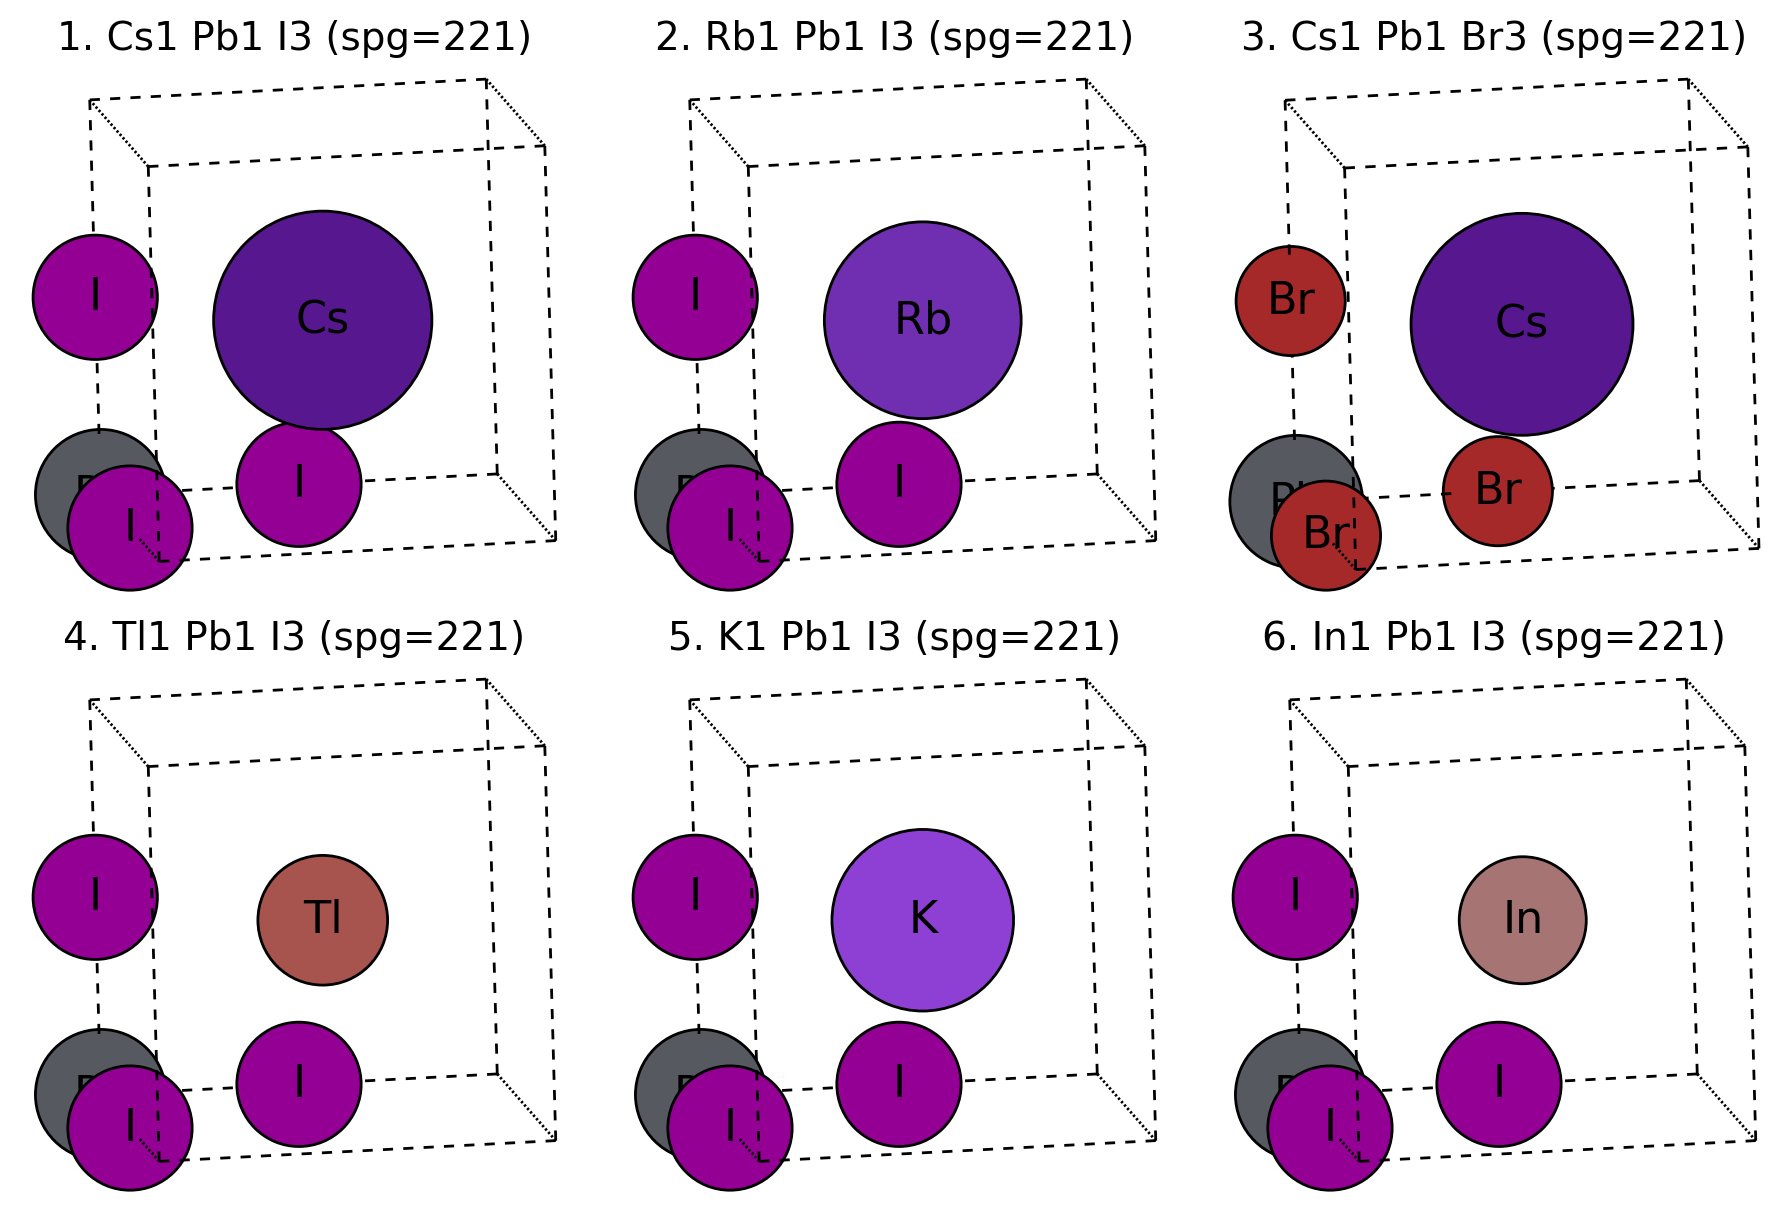

In [12]:
# Visualise the top 5 candidate structures
top_5_structures = [s.as_py_struct() for s in candidate_df["Structure"].head().to_list()]
pmv.structure_2d([cspbi3_sstruct.as_py_struct()] + top_5_structures, n_cols=3)

In [13]:
# note to self, use that python package that removes the answer from the cell
# write another example of how to use the CationMutator

## 3. Storing and Querying Structures with a Database
The `StructureDB` class (in `database.py`) is a thin wrapper around `SQLite`. It lets you add tables, insert structures (as `POSCAR` strings) and query them later. This is useful when you want to build a database of candidate structures for high‑throughput screening.

In the following cell we create an in‑memory database, add a table, and store the structure from Cell 2 (or a dummy structure if Cell 2 failed).

In [14]:
# Below, we create a new database file, add our CsPbI3 structure and candidate structures, and query for structures containing Cs.

# Remove any pre-existing test database file (for a clean start)
db_filename = "test_db.db"
if os.path.exists(db_filename):
    os.remove(db_filename)

# Create the database and add a table.
test_db = StructureDB(db_filename)
test_table = "test_table"
test_db.add_table(test_table)
print(f"Created table '{test_table}' in the database.")

# Add the original CsPbI3 structure.
test_db.add_struct(cspbi3_sstruct, table=test_table)
print("Added the original CsPbI3 structure to the database.")

# Add candidate structures (if any)
if candidate_structures:
    # candidate_structures is a list of tuples; we add the mutated structure from each.
    test_db.add_structs(structs=[s[0] for s in candidate_structures], table=test_table)
    print("Added candidate substituted structures to the database.")

# Query the database: Get structures that contain Cs1+
cs_structs = test_db.get_with_species(species=[("Cs", 1)], table=test_table)
print(f"\nNumber of structures in the database that contain Cs1+: {len(cs_structs)}")

# Query for structures containing both Cs1+ and Pb2+
cs_pb_structs = test_db.get_with_species(species=[("Cs", 1), ("Pb", 2)], table=test_table)
print(f"Number of structures in the database that contain Cs1+ and Pb2+: {len(cs_pb_structs)}")


Created table 'test_table' in the database.
Added the original CsPbI3 structure to the database.
Added candidate substituted structures to the database.

Number of structures in the database that contain Cs1+: 42
Number of structures in the database that contain Cs1+ and Pb2+: 4


The above code blocks demonstrates how to create a `StructureDB` object, store a list of `SmactStructure` objects, and retrieve a list of `SmactStructure` objects from the database by the species present in the structure.

The following example demonstrates how to obtain structures from the Materials Project<sup>*</sup> and store them in the `StructureDB` object. 

<sup>*</sup> The below code assumes that the user has a Materials Project API key from the current (next-gen) version of the MP. If you do not have one, you can obtain one by signing up at https://materialsproject.org/

In [15]:
# ======================================================================
# Cell 7: Adding Materials Project Perovskite Data to the Database
# ======================================================================
"""
We can also use SMACT’s helper functions to populate a database with structures from the Materials Project.
Below, we define a function to get perovskite data and then add the ABO3 perovskite structures to a table.
"""
api_key = os.environ.get("MP_API_KEY")
def get_MP_perovskite_data():
    if api_key is None:
        raise ValueError("No API key found in environment. Please set MP_API_KEY environment variable.")
    
    # Get perovskite data from the Materials Project
    with MPRester(api_key=api_key, use_document_model=False) as mpr:
        robocrys_perov_data = mpr.materials.robocrys.search(keywords=["perovskite"])

    # Get the material ids
    mp_ids  = list(set([d.material_id for d in robocrys_perov_data]))

    # Get the ABO3 perovskites
    with MPRester(api_key=api_key, use_document_model=False) as mpr:
        perov_data = mpr.materials.summary.search(
            material_ids=mp_ids,
            theoretical=False,
            formula="ABC3",
            fields=["material_id","formula_pretty","structure","formula_anonymous","energy_above_hull"]
            )
        
    return perov_data

# Get the perovskite data
perov_data = get_MP_perovskite_data()    


Retrieving RobocrystallogapherDoc documents:   0%|          | 0/8020 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/381 [00:00<?, ?it/s]

In [16]:
# Parse the data to SmactStructure objects

test_db.add_mp_icsd(table="mp_icsd_perovskites",mp_data=perov_data)

Couldn't decorate mp-20325 with oxidation states.
 Couldn't decorate mp-580539 with oxidation states.
 Couldn't decorate mp-10038 with oxidation states.
                                                    Couldn't decorate mp-23482 with oxidation states.
 Couldn't decorate mp-2930 with oxidation states.
 Couldn't decorate mp-31045 with oxidation states.
                                                                                                      Couldn't decorate mp-21135 with oxidation states.
 Couldn't decorate mp-19716 with oxidation states.
 Couldn't decorate mp-21392 with oxidation states.
 Couldn't decorate mp-613402 with oxidation states.
 Couldn't decorate mp-20860 with oxidation states.
                                                   Couldn't decorate mp-559051 with oxidation states.
                                                   Couldn't decorate mp-1188414 with oxidation states.
                                                  Couldn't decorate mp-574239 with

254

```{tip}
From the below code block we have successfully added 254 out of the 381 ABX<sub>3</sub> perovskite structures from the Materials Project to the `StructureDB` object. Structures which cannot be assigned oxidation states are discarded. We can now use the `StructureDB` object to retrieve structures based on the species present in the structure.
```

Number of perovskites with different anions:
F1-: 35
Cl1-: 12
Br1-: 9
I1-: 5
O2-: 175
S2-: 12
N3-: 3


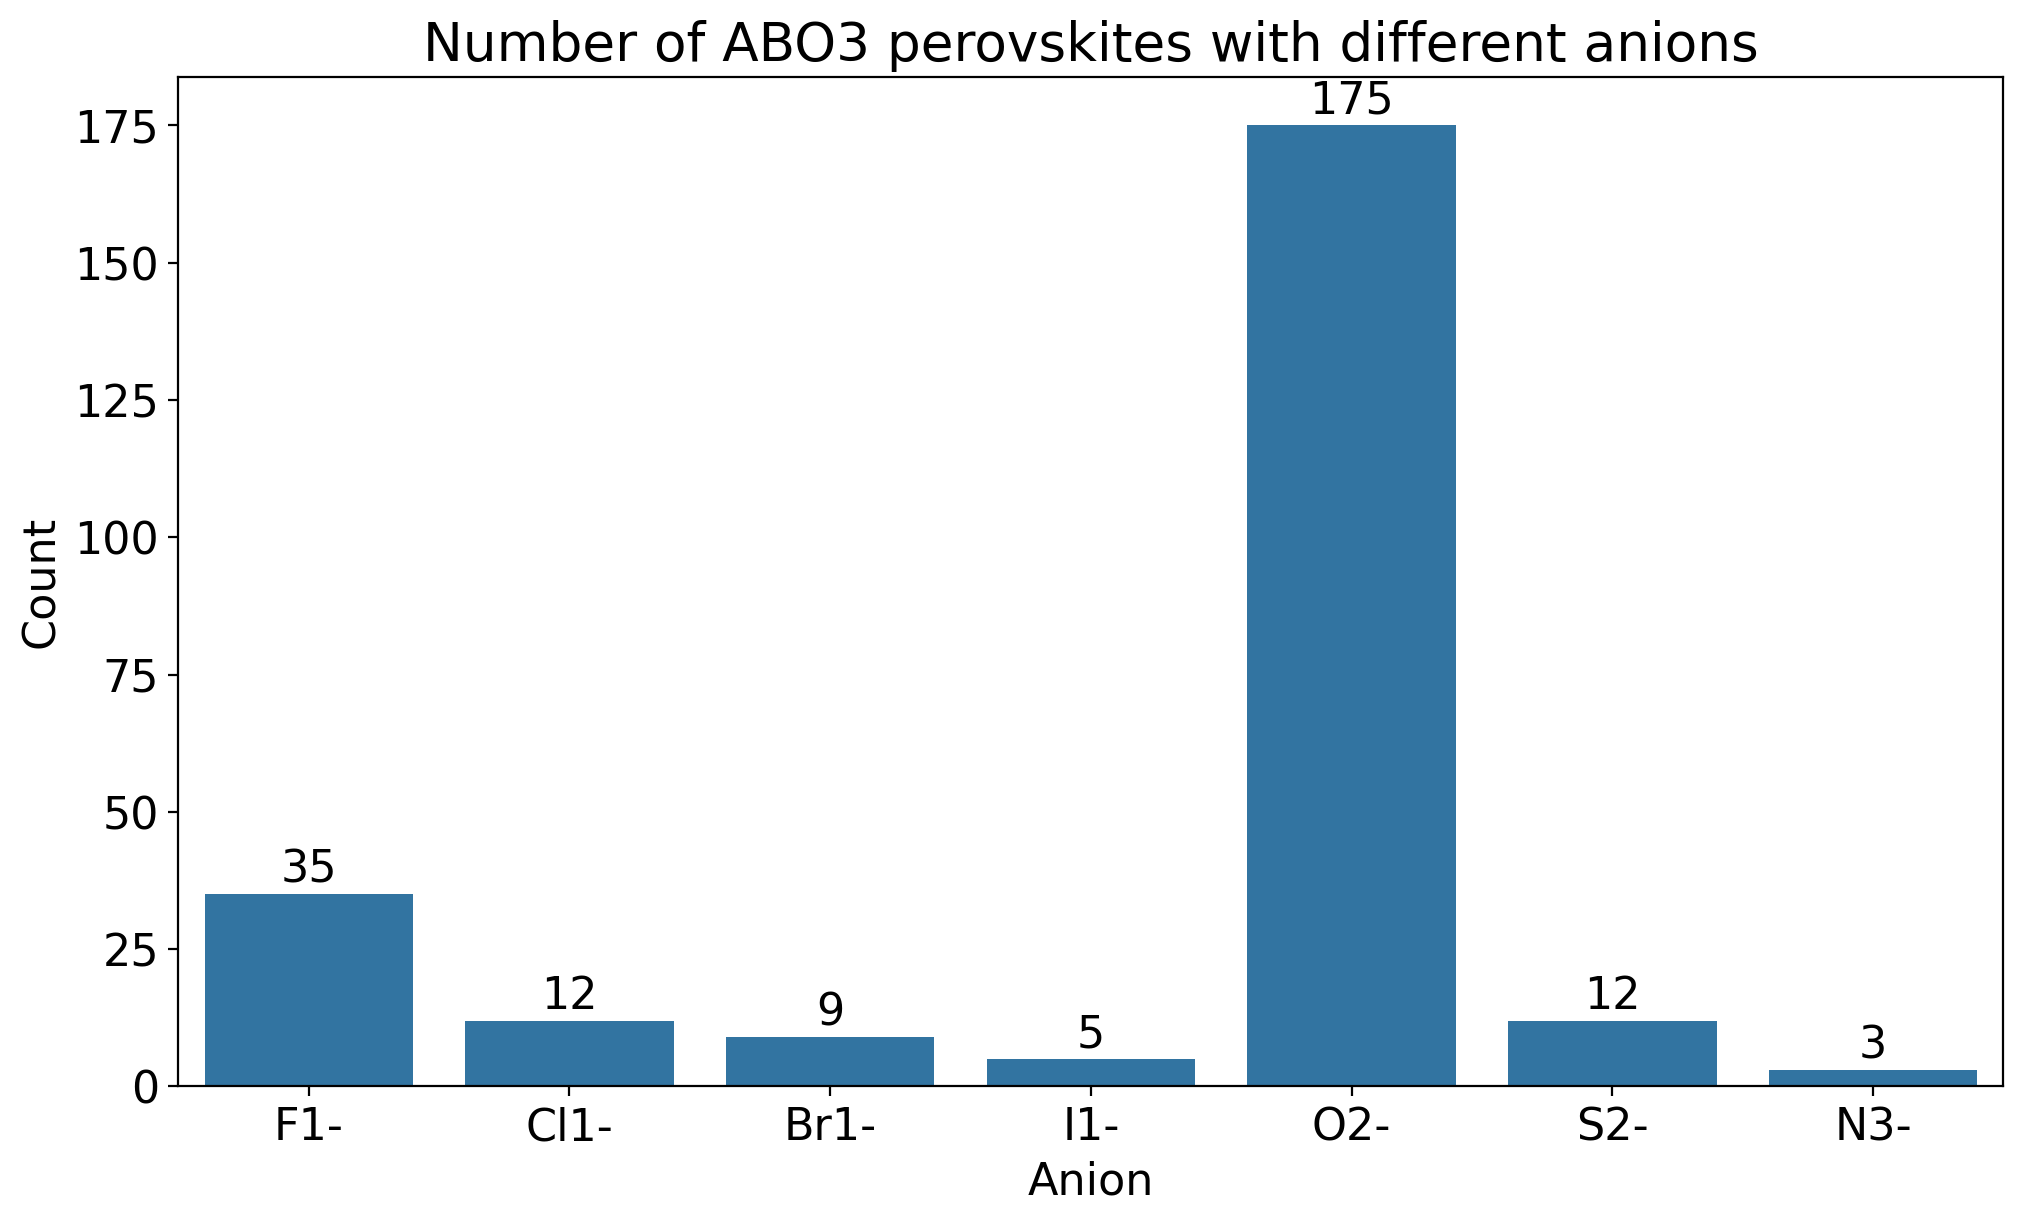

In [17]:

# Count the number of perovskites with different anions in the database

anions = ["F1-","Cl1-","Br1-","I1-","O2-","S2-","N3-"]

anion_counts_dict = {}

for anion in anions:
    anion_counts_dict[anion] = len(test_db.get_with_species(species=[parse_spec(anion)],table="mp_icsd_perovskites"))

# Print the counts
print("Number of perovskites with different anions:")
for anion, count in anion_counts_dict.items():
    print(f"{anion}: {count}")


# Plot the number of perovskites with different anions
anion_counts_df = pd.DataFrame(anion_counts_dict.items(),columns=["Anion","Count"])

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x="Anion",y="Count",data=anion_counts_df,ax=ax)
# Show values on the bars
for i, v in enumerate(anion_counts_df["Count"]):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

ax.set_title("Number of ABO3 perovskites with different anions")
plt.show()




## 4. Structure Prediction from Composition 

The `StructurePredictor` class (in `prediction.py`) combines the substitution probabilities from a mutator with a structure database to propose candidate structures for a target composition. It works by first retrieving “parent” structures from the database and then attempting a substitution to match a target species list.

Below is a simple example that uses the database we just populated with perovskite structures.

We now demonstrate two examples:

1. Predicting structures for a target composition of (Zr⁴⁺, Ta⁵⁺, N³⁻)
2. Predicting substituted CsPbI₃ structures.

### Example 1: Predicting a new structure for (Zr4+, Ta5+, N3-)


Predicting structures for a target composition of Zr4+, Ta5+, N3-:

Result: Zr4+, Ta5+, N3- can be substituted into the structure of ThTaN3 with probability 0.0201


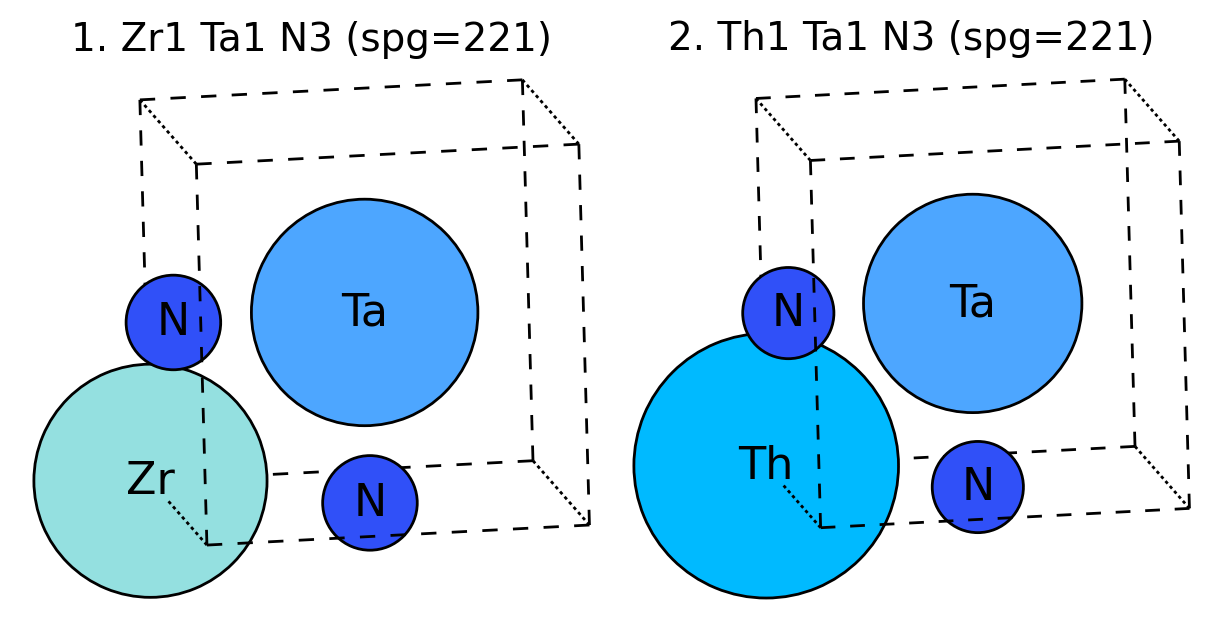

In [18]:

print("\nPredicting structures for a target composition of Zr4+, Ta5+, N3-:")
target_species_1 = [("Zr", 4), ("Ta", 5), ("N", -3)]
# Note: unparse_spec converts tuples to string representations.
parsed_species_1 = [unparse_spec(s) for s in target_species_1]
threshold = 0.001

# Instantiate a predictor using our perovskite database (if available) or the test table.
# Instantiate the StructurePredictor class
predictor = StructurePredictor(mutator=mutator,struct_db=test_db,table="mp_icsd_perovskites")

# Get predictions. The generator yields tuples: (predicted_structure, probability, parent_structure)
try:
    result_gen = predictor.predict_structs(species=target_species_1, thresh=threshold, include_same=False)
    result_0 = next(result_gen)
    pred_struct, prob, parent_struct = result_0
    print(f"\nResult: {unparse_spec(('Zr',4))}, {unparse_spec(('Ta',5))}, {unparse_spec(('N',-3))} can be substituted into the structure of {parent_struct.reduced_formula()} with probability {prob:.3g}")
    
    # Visualize the predicted structure and the template (parent)
    pmv.structure_2d([pred_struct.as_py_struct(), parent_struct.as_py_struct()])
    plt.show()
except StopIteration:
    print("No prediction results found for target species (Zr4+, Ta5+, N3-).")


### Example 2: Predicting substituted CsPbI3 structures.


Predicting substituted structures for CsPbI3:
Predicted composition: CsPbI3 with probability 0.139 substituting into CsPbBr3
Predicted composition: CsPbI3 with probability 0.00415 substituting into CsPbF3
Predicted composition: CsPbI3 with probability 0.00415 substituting into CsPbF3


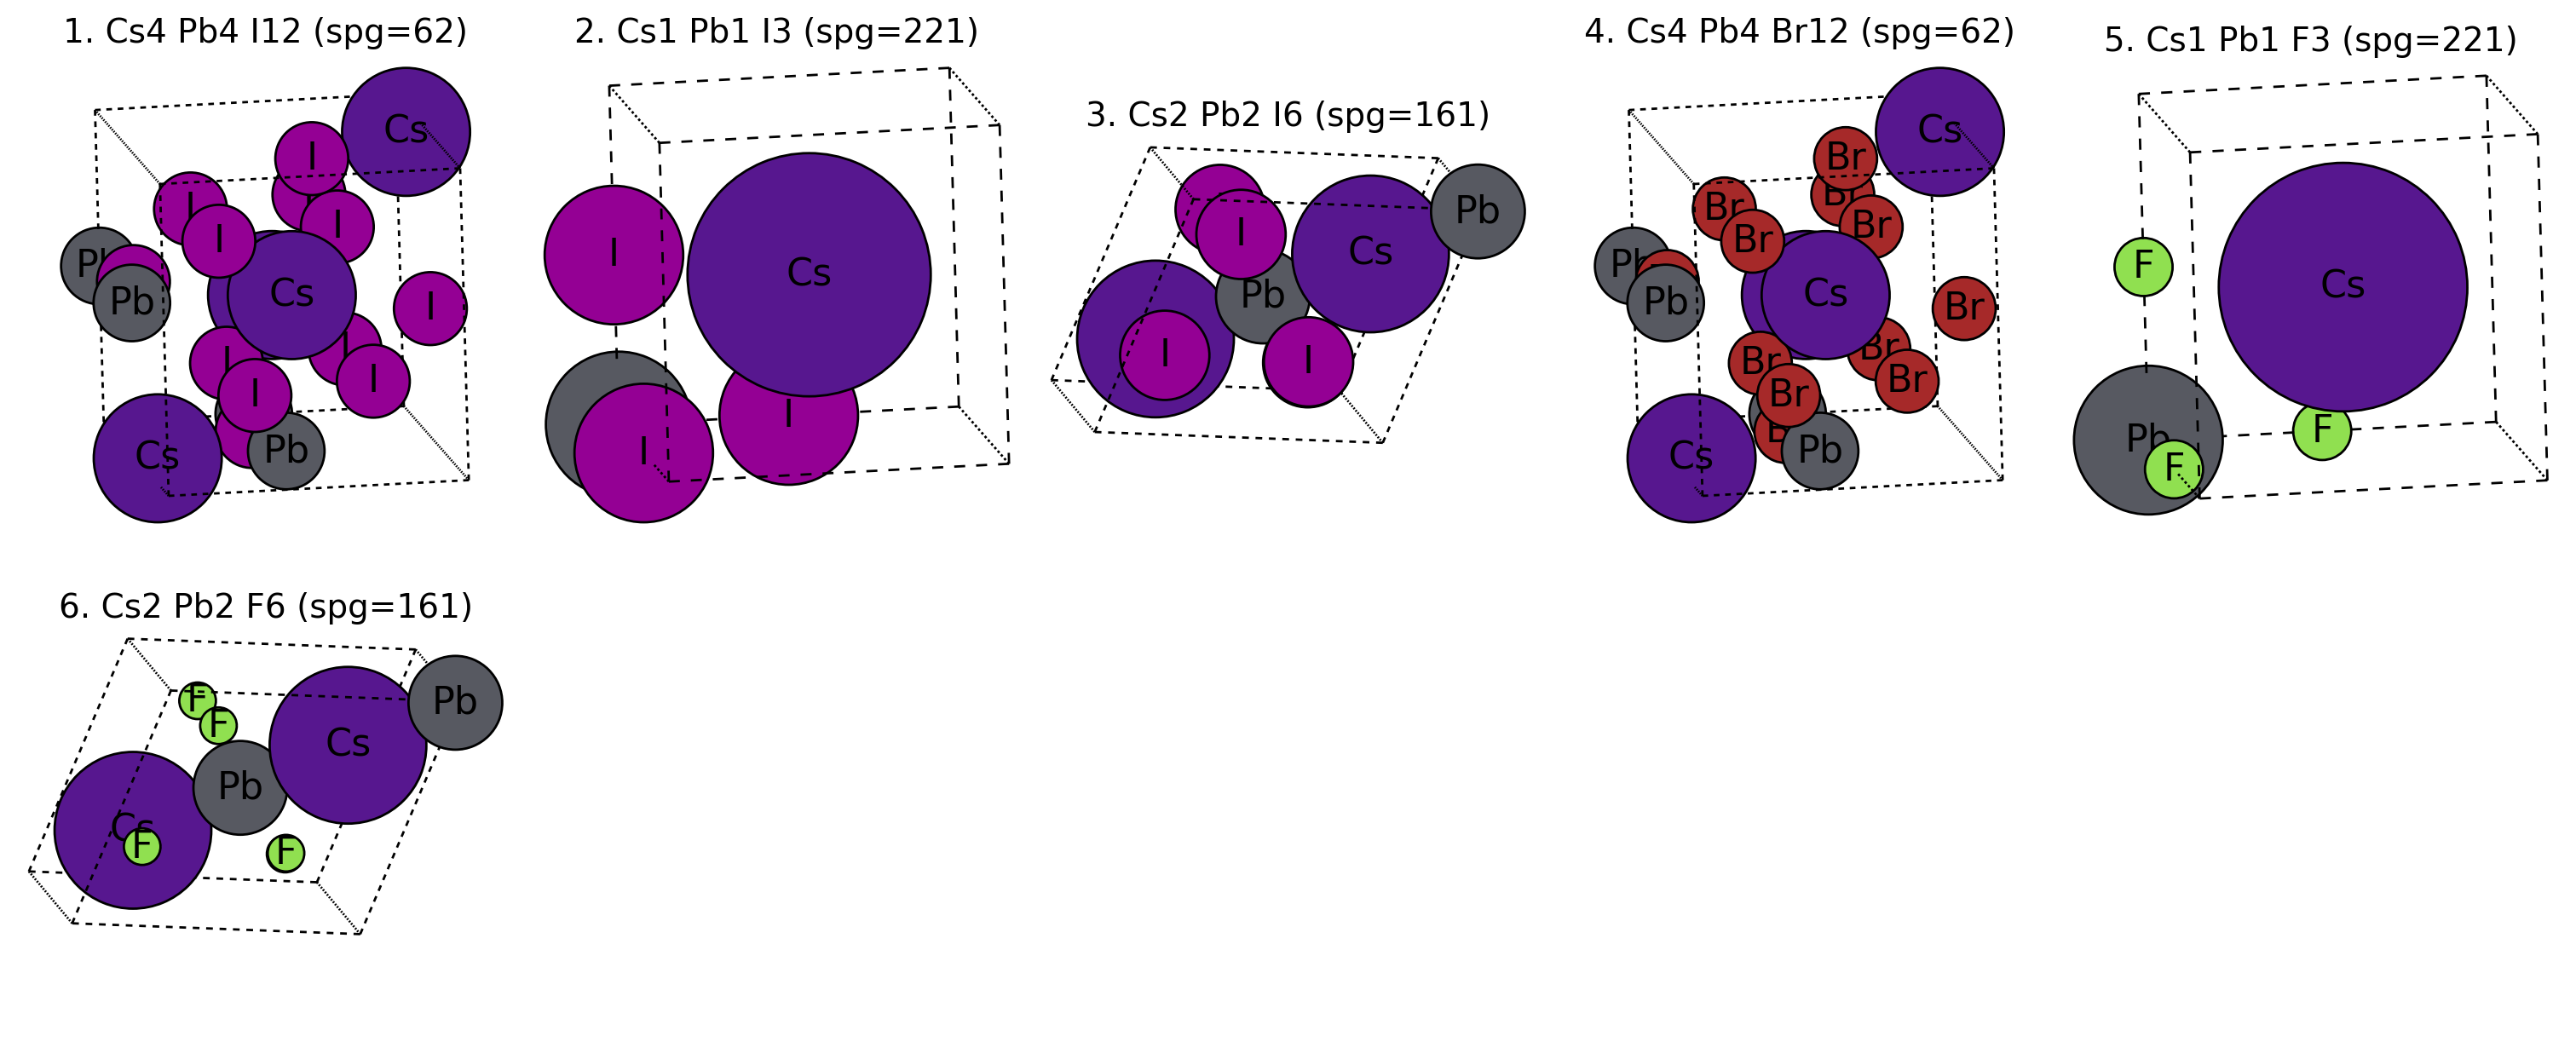

In [19]:

print("\nPredicting substituted structures for CsPbI3:")
target_species_2 = [("Cs", 1), ("Pb", 2), ("I", -1)]
results_cspbi = list(predictor.predict_structs(species=target_species_2, thresh=0.001, include_same=False))
# Sort results by probability (highest first)
results_cspbi.sort(key=itemgetter(1), reverse=True)

for res in results_cspbi:
    pred, p_val, parent = res
    print(f"Predicted composition: {pred.reduced_formula()} with probability {p_val:.3g} substituting into {parent.reduced_formula()}")

# Visualize the top predicted structures along with their parent templates.
if results_cspbi:
    top_predicted = [res[0].as_py_struct() for res in results_cspbi]
    top_parents = [res[2].as_py_struct() for res in results_cspbi]
    # Show predicted structures (top row) and corresponding templates (bottom row)
    all_structs = top_predicted + top_parents
    pmv.structure_2d(all_structs, n_cols=5)
    plt.show()
else:
    print("No CsPbI3 substitution predictions were returned.")

## 5. Next Steps and Conclusion

Congratulations on completing this tutorial!

In this notebook we have learned how to:
  - Retrieve and represent crystal structures with SmactStructure.
  - Compute ionic substitution probabilities and generate candidate doped structures using CationMutator.
  - Store and query structures in a SQLite database with StructureDB.
  - Predict new structures for a target composition with StructurePredictor.
  
### Structure Prediction Extended

Below are several ideas on how to extend the SMACT workflow. These examples cover:

• Integrating your own databases

• Developing custom lambda tables and substitution probability models

• Using alternative probability models with the StructurePredictor

• Expanding your search space via the smact_filter functions


## End of Notebook

This complete tutorial should provide a clear, interactive pathway from chemical composition to structure prediction while allowing you to modify and experiment with the code at each stage. 
Happy coding and materials discovery!
